Описание проекта
Контекст
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

## Обзор и предобработка данных данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from collections import defaultdict
import scipy.stats as stats

In [2]:
visitors = pd.read_csv('visitors.csv')
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')

In [3]:
visitors['date'] = pd.to_datetime(visitors['date'])
display(visitors.head())
display(visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [4]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
pd.options.display.max_colwidth = 210
display(hypothesis)
display(hypothesis.info())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

In [5]:
orders['date'] = pd.to_datetime(orders['date'])
display(orders.head())
display(orders.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

In [6]:
#Важный элемент, смотреть чтобы пользователи не попали в две группы одновременно, поэтому их стоит убрать на этапе предобработки
group_sizes = orders.groupby(['visitorId', 'group']).size().reset_index()
group_sizes.columns = ['visitorId', 'group', 'count']
group_sizes = group_sizes.query('count > 1').sort_values(by='visitorId')
group_sizes

,visitorId,group,count
45,199603092,A,4
58,237748145,A,4
63,249864742,B,3
94,366673373,A,2
104,393266494,B,2
...,...,...,...
1045,4109358064,A,2
1050,4134830387,B,2
1065,4186807279,B,2
1079,4256040402,A,7


In [7]:
potentially_broken_users_list = list(zip(group_sizes['visitorId'], group_sizes['group']))
potentially_broken_users_dict = defaultdict(list)
for user, group in potentially_broken_users_list:
    potentially_broken_users_dict[user].append(group)

inappropriate_users = [user for user in potentially_broken_users_dict if len(potentially_broken_users_dict[user]) > 1]
inappropriate_orders = orders.query('visitorId in @inappropriate_users')
inappropriate_orders_grouped = (inappropriate_orders
                        .groupby(['visitorId', 'group', 'date'])
                        .agg({'transactionId': 'nunique', 'revenue': 'sum'})
                   )
inappropriate_orders_grouped

transactionId  revenue
visitorId  group date                              
1230306981 A     2019-08-09              3    18440
           B     2019-08-09              2    12840
2038680547 A     2019-08-04              2     4070
                 2019-08-17              1     3470
                 2019-08-22              1      760
                 2019-08-25              1      270
           B     2019-08-04              1     2800
                 2019-08-15              1     1680
                 2019-08-29              1     2420
2378935119 A     2019-08-10              1    58220
                 2019-08-15              1     1650
                 2019-08-17              1      310
                 2019-08-22              1     3390
           B     2019-08-09              1    30649
                 2019-08-10              1     2640
                 2019-08-25              1    21220
                 2019-08-28              2    24860
2458001652 A     2019-08-04              1      340
                 2019-08-06              1     1620
                 2019-08-07              1    17379
                 2019-08-11              1     8280
                 2019-08-22              1     5190
           B     2019-08-05              1     2420
                 2019-08-06              2    14030
                 2019-08-08              1     5227
                 2019-08-09              1     5227
                 2019-08-25              1     2385
4256040402 A     2019-08-01              1     5800
                 2019-08-12              1       50
                 2019-08-17              1     1550
                 2019-08-20              1    17650
                 2019-08-23              1    16950
                 2019-08-27              1     1630
                 2019-08-31              1     5170
           B     2019-08-08              1    58220
                 2019-08-16              1    56650
                 2019-08-18              1    10970
                 2019-08-31              1     1850

In [8]:
inappropriate_orders_grouped = inappropriate_orders_grouped.reset_index()
inappropriate_orders_grouped['count'] = -1
inappropriate_orders_grouped = inappropriate_orders_grouped[['group', 'date', 'count']]
visitors_filt = visitors.merge(inappropriate_orders_grouped, on=['date', 'group'], how='left').fillna(0)
visitors_filt['visitors_'] = visitors_filt['visitors'] + visitors_filt['count']
visitors_filt = visitors_filt.drop(['visitors', 'count'], axis=1)
visitors_filt.columns = ['date', 'group', 'visitors']
visitors_filt['visitors'] = visitors_filt['visitors'].astype(int)

In [9]:
orders_filt = orders.query('visitorId not in @inappropriate_orders')
clean_count_orders = orders_filt.groupby('visitorId')['transactionId'].count()
clean_count_orders = clean_count_orders[clean_count_orders > 2].index.tolist()
clean_sum_orders = orders_filt.groupby('visitorId')['revenue'].max()
clean_sum_orders = clean_sum_orders[clean_sum_orders > 28000].index.tolist()
orders_common = list(set(clean_count_orders + clean_sum_orders))
orders_final = orders_filt.query('visitorId not in @ orders_common')
orders_final

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A


### Часть 1. Приоритизация гипотез.

#### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [10]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'],2)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


#### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета. Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [11]:
hypothesis['RICE'] = round((hypothesis['reach']*hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'],2)
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [12]:
hypothesis[['hypothesis','RICE','ICE']].sort_values(by=['RICE','ICE'], ascending=False)

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


### Вывод
Отличие результатов ICE от RICE связано с тем, что некоторые гипотезы имеют более высокий показатель охвата. <br>
Пример: Добавить форму подписки на все основные страницы<br>
По RICE она имеет высокий приоритет из за большого охвата, но по ICE занимает третье место из за низкого влияния и уверенности 

## Часть 2. Анализ A/B-теста

#### 1.Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [13]:
datesGroups = orders[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


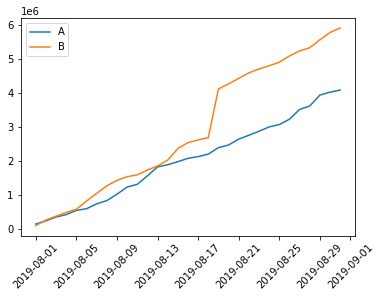

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.rcParams["figure.figsize"] = (9,9)
plt.xticks(rotation = 45)
plt.legend();

<b>Вывод:</b> В целом выручка растет, причем у группы В есть скачок. Вероятно есть аномалии. Необходим детальный анализ чеков и количества заказов.

#### 2.Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.|

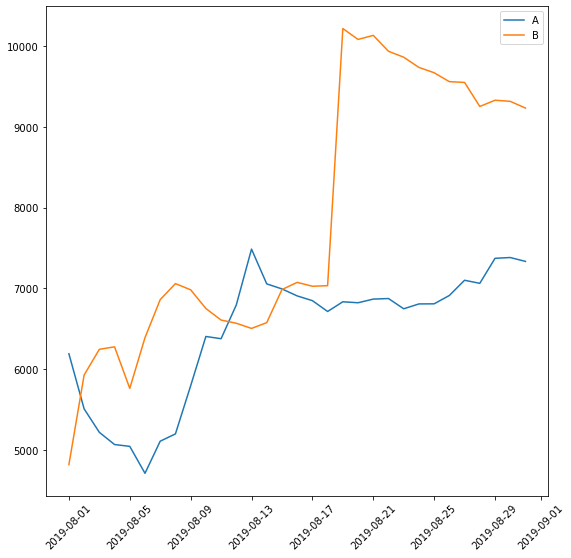

In [15]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation = 45)
plt.show();

<b>Вывод:</b> Значение среднего чека растет, но тоже нестабильно. У группы А оно перешло в стагнацию во второй половине теста.
    У В безумный скачок, после которого пошло снижение. На лицо наличие аномальных значений по сумме заказа

#### 3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

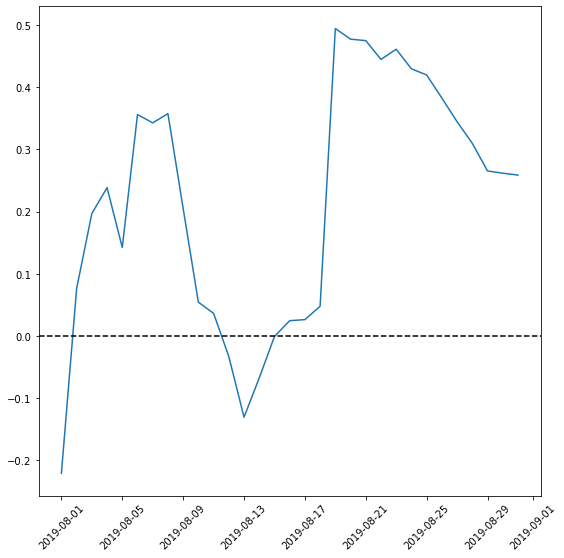

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation = 45)
plt.show();

<b>Вывод:</b>Такие волны говорят о наличии крупных заказов. Найдем их в дальнейшем

#### 4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

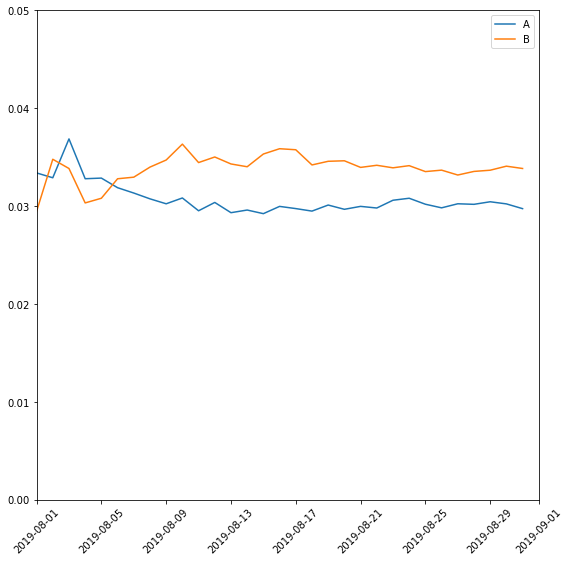

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]) 
plt.xticks(rotation = 45)
plt.show();

<b>Вывод:</b> После первых дней теста,конверсия В вышла вперед и зафиксировалась, значения группы А ниже, но тоже стабильны

#### 5.Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

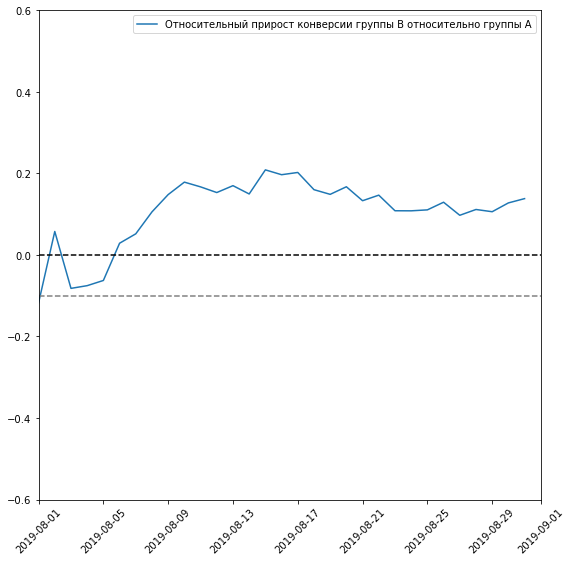

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.6, 0.6]) 
plt.xticks(rotation = 45)
plt.show();

<b>Вывод:</b> Группа В после пары дней показала рост и зафиксировалась на уровне. Для получения полной картины необходимо подчистить аномалии

#### 6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [19]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


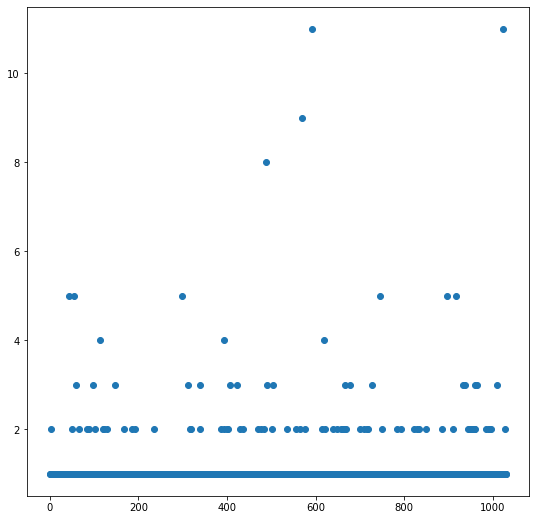

In [20]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.show();

<b>Вывод:</b> Большинство заказов находятся в интервале от 0 до 4, однако есть аномалии в 11 заказов. Многовато

#### 7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [21]:
print(np.percentile(ordersByUsers['orders'], [ 95, 99]))
#Выставляю границу до 4 заказов

[2. 4.]


#### 8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

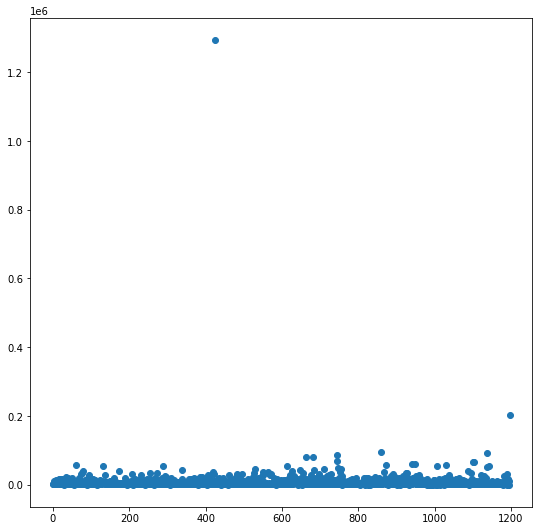

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

<b>Вывод:</b> Большинство заказов находятся в интервале от 0 до 200000, однако есть аномалия в 12000000. Странно крупный заказ.

#### 9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [23]:
print(np.percentile(orders['revenue'], [ 95, 99]))
#Выставляю границу в 28000

[28000.  58233.2]


#### 10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
#### 12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

Используем тест Уилкоксона-Манна-Уитни, из-за наличия выбросов, а сам тест работает с рангами, не учитывая сами значения.<br>
Порогом статистической значимости установим alpha=.05
<br>


In [24]:
#Н0: статистическая значимость не значительна и сделать вывод о различии нельзя
#Н1: статистическая значимость значительная и между выборками имеется статистическая значимость.

#p-value  по сырым данным
orders_conversion = orders_filt.groupby(['date', 'group'])['visitorId'].nunique().to_frame().reset_index()

df_conv_comparison = orders_conversion.merge(visitors, on=['date', 'group'])
df_conv_comparison['conversion'] = (df_conv_comparison['visitorId'] / df_conv_comparison['visitors']).round(4)
df_conv_comparison = df_conv_comparison[['date', 'group', 'conversion']]

conv_A = df_conv_comparison.query('group == "A"')['conversion'].tolist()
conv_B = df_conv_comparison.query('group == "B"')['conversion'].tolist()
conv_A_mean = sum(conv_A) / len(conv_A)
conv_B_mean = sum(conv_B) / len(conv_B)

#p-value - по очищенным данным
orders_conversion_clean = orders_final.groupby(['date', 'group'])['visitorId'].nunique().to_frame().reset_index()

df_conv_comparison_clean = orders_conversion_clean.merge(visitors, on=['date', 'group'])
df_conv_comparison_clean['conversion'] = (df_conv_comparison_clean['visitorId']/df_conv_comparison_clean['visitors'])
df_conv_comparison_clean['conversion'] = df_conv_comparison_clean['conversion'].round(4)
df_conv_comparison_clean = df_conv_comparison_clean[['date', 'group', 'conversion']]

conv_clean_A = df_conv_comparison_clean.query('group == "A"')['conversion'].tolist()
conv_clean_B = df_conv_comparison_clean.query('group == "B"')['conversion'].tolist()
conv_A_mean_cleared = sum(conv_clean_A)/len(conv_clean_A)
conv_B_mean_cleared = sum(conv_clean_B)/len(conv_clean_B)
alpha = .05
p_val_conv = stats.mannwhitneyu(conv_A, conv_B)[1].round(5)
p_val_conv_clean = stats.mannwhitneyu(conv_clean_A, conv_clean_B)[1].round(5)
print('P-value по конверсии до очистки данных: {}'.format(p_val_conv))
if (p_val_conv < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Отношения средних B/A по конверсии (до очистки данных): {:.2f}'.format(conv_B_mean/conv_A_mean))
print('P-value по конверсии после очистки данных: {}'.format(p_val_conv_clean))
if (p_val_conv_clean < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Отношения средних B/A по конверсии (после очистки данных): {:.2f}'.format
                                                                          (conv_B_mean_cleared/conv_A_mean_cleared))

P-value по конверсии до очистки данных: 0.03745
Отвергаем нулевую гипотезу
Отношения средних B/A по конверсии (до очистки данных): 1.16
P-value по конверсии после очистки данных: 0.0148
Отвергаем нулевую гипотезу
Отношения средних B/A по конверсии (после очистки данных): 1.19


<b>Вывод:</b>Отвергаем нулевую гипотезу. Подтвержаем наличие различий между группами. Группа В дает результаты по конверсии и отличается от группы А. Различие составляет 16-19 процентов до и после очистки соответственно.

#### 11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
#### 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [25]:
#Н0: различий в конверсии нет
#Н1: есть различия в конверсиях 

mean_check_A = orders_filt[orders_filt['group'] == 'A']['revenue']
mean_check_B = orders_filt[orders_filt['group'] == 'B']['revenue']
mean_check_A_final = sum(mean_check_A) / len(mean_check_A)
mean_check_B_final = sum(mean_check_B) / len(mean_check_B)

mean_check_clean_A = orders_final[orders_final['group'] == 'A']['revenue']
mean_check_clean_B = orders_final[orders_final['group'] == 'B']['revenue']
mean_check_clean_A_final = sum(mean_check_clean_A) / len(mean_check_clean_A)
mean_check_clean_B_final = sum(mean_check_clean_B) / len(mean_check_clean_B)

p_val_mean_check_clean = stats.mannwhitneyu(mean_check_clean_A, mean_check_clean_B)[1].round(2)
p_val_mean_check = stats.mannwhitneyu(mean_check_A, mean_check_B)[1].round(2)
alpha = .05
print('P-value по среднему чеку до очистки данных: {}'.format(p_val_mean_check))
if (p_val_mean_check < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Отношения  B/A по среднему чеку (до очистки данных): {:.2f}'.format(mean_check_B_final/mean_check_A_final))
print('P-value среднему чеку после очистки данных: {}'.format(p_val_mean_check_clean))
if (p_val_mean_check_clean < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Отношения B/A по среднему чеку (после очистки данных): {:.2f}'.format
                                                                          (mean_check_clean_B_final/mean_check_clean_A_final))

P-value по среднему чеку до очистки данных: 0.36
Не получилось отвергнуть нулевую гипотезу
Отношения  B/A по среднему чеку (до очистки данных): 1.26
P-value среднему чеку после очистки данных: 0.38
Не получилось отвергнуть нулевую гипотезу
Отношения B/A по среднему чеку (после очистки данных): 0.98


<b>Вывод:</b>А вот по среднему чеку различие нет, нулевую гипотезу не можем отвергнуть. После очистки группа В потеряла 28 процентов в отношении средних чеков

#### 14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Остановить тест, зафиксировать победу группы В, поскольку конверсия группы В выше.